# Perplexity ratio score exploratory data analysis

In [ ]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import seaborn as sns # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from statistics import mean

import configuration as config
import functions.data_manipulation as data_funcs
import functions.plotting as plot_funcs

/mnt/arkk/llm_detector/benchmarking


## 1. Benchmark data

In [2]:
# Load the data sets
self_comparison_data_df = pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/perplexity_ratio_model_benchmark.jsonl', lines=True, orient='records')

# Translation dict for column names
column_renaming_dict = {
    'hf_model_string': 'Scoring model',
    'perplexity_ratio_score': 'Perplexity ratio score',
    'perplexity': 'Perplexity',
    'cross-perplexity': 'Cross-perplexity',
    'length_words': 'Input length (words)',
    'length_tokens': 'Input length (tokens)',
    'data_source': 'Data source',
    'generating_model': 'Generation model',
    'reader_model': 'Reader model',
    'writer_model': 'Writer model',
    'reader_device': 'Reader device',
    'writer_device': 'Writer device',
    'author': 'Author',
    'device_map': 'Device',
    'iteration': 'Iteration',
    'text': 'Text'
}

# Translation dict for string values
value_renaming_dict = {
    'cuda:1': 'NVIDIA K80',
    'cuda:2': 'NVIDIA k80',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B',
    'google/gemma-2-9b': 'Gemma2-9B',
    'meta-llama/Meta-Llama-3-8B-instruct': 'LLaMA3-8B instruct',
    'tiiuae/falcon-7b-instruct': 'Falcon-7B instruct',
    'mistralai/Mistral-7B-Instruct-v0.3': 'Mistral-7B instruct',
    'meta-llama/Llama-2-7b-chat-hf': 'LLaMA2-7b chat',
    'google/gemma-2-9b-it': 'Gemma2-9B instruct'
}

# Translate column names and string values for pretty printing in plots
self_comparison_data_df = plot_funcs.replace_strings(
    df = self_comparison_data_df,
    column_renaming_dict = column_renaming_dict,
    value_renaming_dict = value_renaming_dict
)

# Replace string NAN and OOM values with np.NAN
self_comparison_data_df = plot_funcs.clean_nan_oom(self_comparison_data_df)

# Drop np.NAN rows
self_comparison_data_df.dropna(inplace = True)

# Fix some d-types
self_comparison_data_df = self_comparison_data_df.astype({
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

print('\nModel self comparison data:')
self_comparison_data_df.info()
self_comparison_data_df.head(3)


Model self comparison data:
<class 'pandas.core.frame.DataFrame'>
Index: 4547 entries, 0 to 5002
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Iteration               4547 non-null   float64
 1   Scoring model           4547 non-null   object 
 2   Device                  4547 non-null   object 
 3   Perplexity ratio score  4547 non-null   float64
 4   Perplexity              4547 non-null   float64
 5   Cross-perplexity        4547 non-null   float64
 6   Input length (words)    4547 non-null   float64
 7   Input length (tokens)   4547 non-null   float64
 8   Data source             4547 non-null   object 
 9   Generation model        4547 non-null   object 
 10  Reader model            4547 non-null   object 
 11  Writer model            4547 non-null   object 
 12  Reader device           4547 non-null   object 
 13  Writer device           4547 non-null   object 
 14  Author          

,Iteration,Scoring model,Device,Perplexity ratio score,Perplexity,Cross-perplexity,Input length (words),Input length (tokens),Data source,Generation model,Reader model,Writer model,Reader device,Writer device,Author,Text
0,1.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.767108,1.551342,2.022326,138.0,364.0,cc_news,falcon7,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"vs Top 10: 1-3 (L-Bisping, L-Weidman, L-Weidma..."
1,2.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.773936,2.313174,2.988844,219.0,272.0,pubmed,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,synthetic,problem in people over 60 years old and one of...
2,3.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",1.055911,3.332735,3.156264,87.0,108.0,cnn,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"Ayatollah Sadegh Larijani, who heads Iran's ju..."


## 2. Model comparisons

First comparison to make is by model. Here, the reader and writer models are the base and instruct versions of the same model.

In [ ]:
from scipy.stats import ttest_ind # type: ignore

# Get reader model names
reader_models = self_comparison_data_df['Reader model'].unique()

print('t-test for difference in perplexity ratio score mean (H1: human > synthetic):\n')

# Loop on models and run t-test
for reader_model in reader_models:
    human_prs = self_comparison_data_df['Perplexity ratio score'][(self_comparison_data_df['Reader model'] == reader_model) & (self_comparison_data_df['Author'] == 'human') ]
    synthetic_prs = self_comparison_data_df['Perplexity ratio score'][(self_comparison_data_df['Reader model'] == reader_model) & (self_comparison_data_df['Author'] == 'synthetic') ]

    ttest_result = ttest_ind(human_prs, synthetic_prs, alternative='greater')
    print(f' Model: {reader_model}, p-value = {ttest_result.pvalue}')

t-test for difference in perplexity ratio score mean (H1: human > synthetic):

 Model: LLaMA3-8B, p-value = 1.5729481231979171e-63
 Model: Falcon-7B, p-value = 1.468072030319169e-94
 Model: Mistral-7B, p-value = 1.616176097989206e-36
 Model: LLaMA2-7B, p-value = 2.750820755073135e-80
 Model: Gemma2-9B, p-value = 0.0007156726011347075


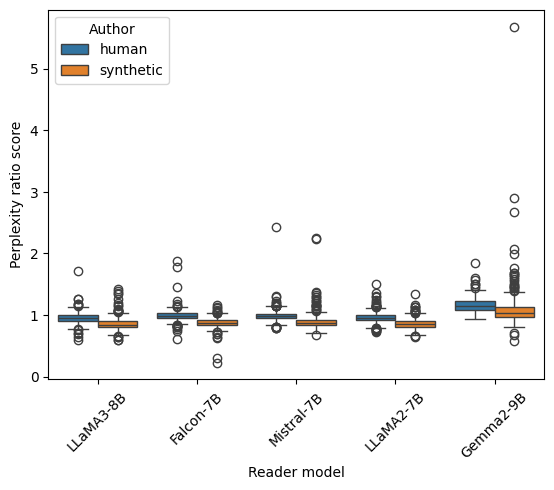

In [4]:
ax = sns.boxplot(data = self_comparison_data_df, x = 'Reader model', y = 'Perplexity ratio score', hue = 'Author')
ax.tick_params(axis = 'x', labelrotation = 45)
plt.show()

OK, cool - so they are all definitely different. Interestingly, we are the least confident about the difference in means for gemma2-9b (probably the most advanced model of the bunch). Looking at the plot, it's perplexity ratio scores tend to be the largest and have a bigger spread than the other models.

But who wins? I.e. which model gives the largest difference in means?

In [ ]:
import numpy as np # type: ignore
import statsmodels.stats.api as sms # type: ignore
from statistics import mean

# Loop on models and run t-test
for reader_model in reader_models:

    # Pull the data for this model
    human_prs = self_comparison_data_df['Perplexity ratio score'][(self_comparison_data_df['Reader model'] == reader_model) & (self_comparison_data_df['Author'] == 'human') ]
    synthetic_prs = self_comparison_data_df['Perplexity ratio score'][(self_comparison_data_df['Reader model'] == reader_model) & (self_comparison_data_df['Author'] == 'synthetic') ]

    # Get the means in question and their difference
    human_mean = mean(human_prs)
    synthetic_mean = mean(synthetic_prs)
    mean_diff = human_mean - synthetic_mean

    cm = sms.CompareMeans(sms.DescrStatsW(human_prs), sms.DescrStatsW(synthetic_prs))
    difference = cm.tconfint_diff(usevar='unequal')
    low_bound = difference[0]
    high_bound = difference[1]
    print(f'Model: {reader_model}, difference in means = {mean_diff:.3f}, 95% CI = ({low_bound:.3f}, {high_bound:.3f})')

Model: LLaMA3-8B, difference in means = 0.102, 95% CI = (0.091, 0.113)
Model: Falcon-7B, difference in means = 0.116, 95% CI = (0.106, 0.126)
Model: Mistral-7B, difference in means = 0.091, 95% CI = (0.077, 0.105)
Model: LLaMA2-7B, difference in means = 0.110, 95% CI = (0.099, 0.120)
Model: Gemma2-9B, difference in means = 0.072, 95% CI = (0.033, 0.111)


Looks like Falcon-7B is the winner: smallest p-value, largest difference and highest low bound.

## 3. LLaMA3-8B vs Falcon-7B
The original paper used LLaMA2-7B, which is actually one of the weaker models for this task according to the results above. We have been using LLaMA3-8B, so let's compare that to Falcon-7B.

In [6]:
# Load LLaMA datasets
llama_datasets = [
    'cc_news-scores.json',
    'cnn-scores.json',
    'pubmed-scores.json'
]

# Loop and load/collect dataframes
llama_dfs = []

for llama_dateset in llama_datasets:

    # Load
    data_df = pd.read_json(f'{config.HANS_DATA_PATH}/{llama_dateset}')

    # Fix column naming
    data_df.columns = ['Fragment', 'Fragment length (tokens)', 'Dataset', 'Source', 'String', 'Reader peak memory (GB)', 'Writer peak memory (GB)', 'Perplexity', 'Cross-perplexity', 'Perplexity ratio score']

    # Collect
    llama_dfs.append(data_df)

# Concatenate the collected dataframes
llama_data_df = pd.concat(llama_dfs)

# Replace and remove string 'OOM' and 'NAN' values
llama_data_df.replace('NAN', np.nan, inplace = True)
llama_data_df.replace('OOM', np.nan, inplace = True)
llama_data_df.dropna(inplace = True)

# Fix some d-types
llama_data_df = llama_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

llama_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121012 entries, 0 to 52920
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Fragment                  121012 non-null  int64  
 1   Fragment length (tokens)  121012 non-null  int64  
 2   Dataset                   121012 non-null  object 
 3   Source                    121012 non-null  object 
 4   String                    121012 non-null  object 
 5   Reader peak memory (GB)   121012 non-null  float64
 6   Writer peak memory (GB)   121012 non-null  float64
 7   Perplexity                121012 non-null  float64
 8   Cross-perplexity          121012 non-null  float64
 9   Perplexity ratio score    121012 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 10.2+ MB


In [7]:
# Load the falcon data
falcon_data_df = pd.read_json(f'{config.HANS_DATA_PATH}/falcon-7b_scores.json')

# Replace and remove string 'OOM' and 'NAN' values
falcon_data_df.replace('NAN', np.nan, inplace = True)
falcon_data_df.replace('OOM', np.nan, inplace = True)
falcon_data_df.dropna(inplace = True)

# Fix some d-types
falcon_data_df = falcon_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

falcon_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26624 entries, 0 to 26630
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment                  26624 non-null  int64  
 1   Fragment length (tokens)  26624 non-null  int64  
 2   Dataset                   26624 non-null  object 
 3   Source                    26624 non-null  object 
 4   String                    26624 non-null  object 
 5   Reader peak memory (GB)   26624 non-null  float64
 6   Writer peak memory (GB)   26624 non-null  float64
 7   Perplexity                26618 non-null  float64
 8   Cross-perplexity          26624 non-null  float64
 9   Perplexity ratio score    26618 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 2.2+ MB


In [8]:
# Separate out the human an synthetic fragments from each dataset for plotting
llama_human_fragments = llama_data_df[llama_data_df['Source'] == 'human']
llama_synthetic_fragments = llama_data_df[llama_data_df['Source'] == 'synthetic']

falcon_human_fragments = falcon_data_df[falcon_data_df['Source'] == 'human']
falcon_synthetic_fragments = falcon_data_df[falcon_data_df['Source'] == 'synthetic']

### 2.1. Perplexity vs cross-perplexity

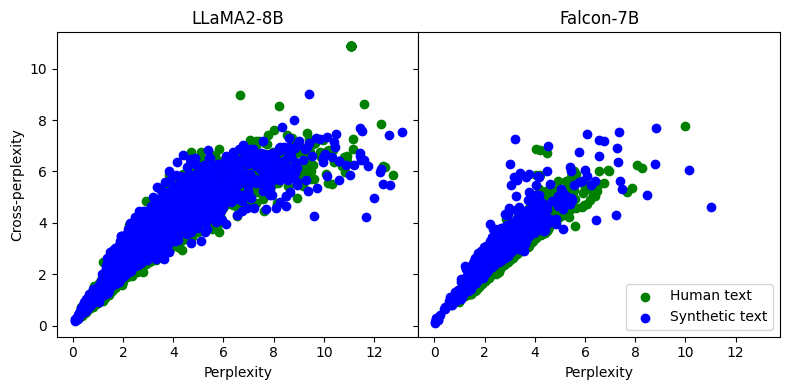

In [9]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex=True,
    sharey=True,
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('LLaMA3-8B')
axs[0].scatter(llama_human_fragments['Perplexity'], llama_human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0].scatter(llama_synthetic_fragments['Perplexity'], llama_synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0].set_xlabel('Perplexity')
axs[0].set_ylabel('Cross-perplexity')

axs[1].set_title('Falcon-7B')
axs[1].scatter(falcon_human_fragments['Perplexity'], falcon_human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[1].scatter(falcon_synthetic_fragments['Perplexity'], falcon_synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[1].set_xlabel('Perplexity')

axs[1].legend(loc = 'lower right')

plt.show()

### 2.2. Perplexity ratio score distribution

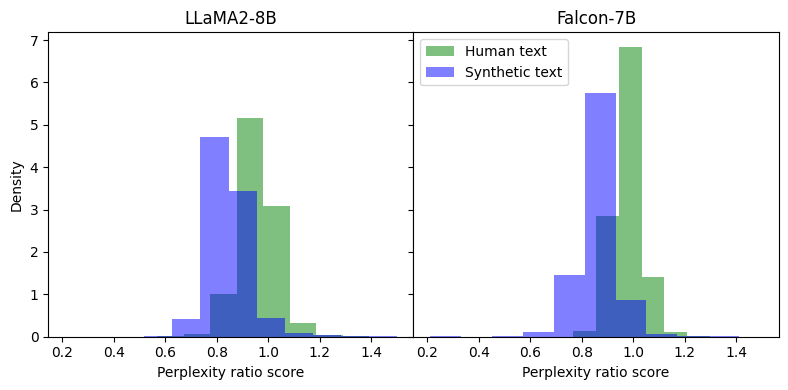

In [10]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex=True,
    sharey=True,
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('LLaMA3-8B')
axs[0].hist(llama_human_fragments['Perplexity ratio score'][llama_human_fragments['Perplexity ratio score'] < 1.5], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0].hist(llama_synthetic_fragments['Perplexity ratio score'][llama_synthetic_fragments['Perplexity ratio score'] < 1.5], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0].set_ylabel('Density')
axs[0].set_xlabel('Perplexity ratio score')

axs[1].set_title('Falcon-7B')
axs[1].hist(falcon_human_fragments['Perplexity ratio score'][falcon_human_fragments['Perplexity ratio score'] < 1.5], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1].hist(falcon_synthetic_fragments['Perplexity ratio score'][falcon_synthetic_fragments['Perplexity ratio score'] < 1.5], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1].set_xlabel('Perplexity ratio score')

axs[1].legend(loc = 'upper left')

plt.show()

### 2.3. Binoculars score by fragment length

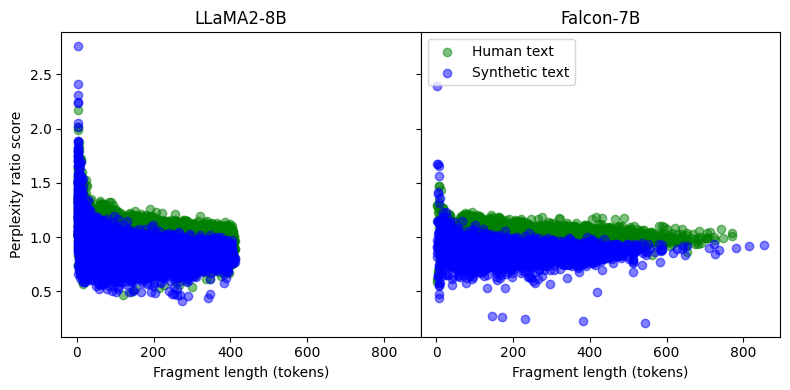

In [11]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex=True,
    sharey=True,
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('LLaMA3-8B')
axs[0].scatter(llama_human_fragments['Fragment length (tokens)'], llama_human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[0].scatter(llama_synthetic_fragments['Fragment length (tokens)'], llama_synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[0].set_ylabel('Perplexity ratio score')
axs[0].set_xlabel('Fragment length (tokens)')

axs[1].set_title('Falcon-7B')
axs[1].scatter(falcon_human_fragments['Fragment length (tokens)'], falcon_human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1].scatter(falcon_synthetic_fragments['Fragment length (tokens)'], falcon_synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1].set_xlabel('Fragment length (tokens)')

axs[1].legend(loc = 'upper left')

plt.show()

The lengths are interesting here - it looks like LLaMA has a hard cutoff at just over 400 tokens, while Falcon scores some fragments twice that long. I think this is down the memory footprint of the models and differences in the tokenizers. In our benchmarking, we could calculate logits for sequences of up to ~700 words with Falcon, but only ~300-400 words with LLaMA3. The perplexity scoring script has a hard cutoff at 300 words for this reason, and only generates samples of 50 - 300 words. However, the graph above shows length in tokens, not words, so it must be that Falcon is making some sub 300 word inputs into 600-700 tokens or more, while LLaMA3 never ends up with much past 400 tokens.

We could maybe relax the length window a bit, it also might be cool to relax it a lot and alow long sequences. To do this we would have to switch device maps on the fly and send very long inputs to CPU or maybe mixed GPU/CPU.

Anyway, seems a little funny, but let's move on.

### 2.4. Fragment length distribution

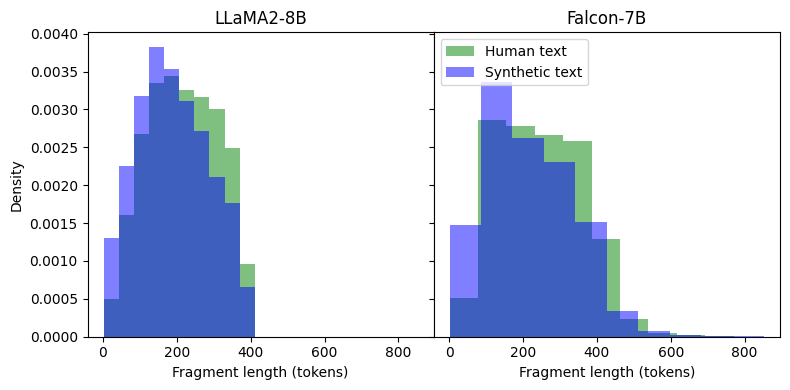

In [12]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex=True,
    sharey=True,
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('LLaMA2-8B')
axs[0].hist(llama_human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0].hist(llama_synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0].set_ylabel('Density')
axs[0].set_xlabel('Fragment length (tokens)')

axs[1].set_title('Falcon-7B')
axs[1].hist(falcon_human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1].hist(falcon_synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1].set_xlabel('Fragment length (tokens)')

axs[1].legend(loc = 'upper left')

plt.show()